# HW3 - John Pezzuto

### Load Packages, Data, & Functions

In [1]:
import numpy as np
import scipy.optimize as opt
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import scipy.integrate as intgr
import numpy.linalg as lin
plt.style.use("ggplot")
%matplotlib inline

In [2]:
incomes = np.loadtxt('incomes.txt')
sick = pd.read_csv("sick.txt")
#simulated income
inc_sim = np.linspace(0.000001, 150000, 200)

In [3]:
def trunc_lognorm_pdf(xvals, mu, sigma, cutoff):
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    log_pdf_vals = (((1/(xvals * sigma * np.sqrt(2 * np.pi))) *
                    np.exp( - ((np.log(xvals)) - mu)**2 / (2 * sigma**2))) / 
                    prob_notcut)
    return log_pdf_vals 

## data mean & std
def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std()
    return mean_data, std_data

## model mean & std
def model_moments(mu, sigma, cutoff):
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0.00001, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0.00001, cutoff)
    std_model = np.sqrt(var_model)
    return mean_model, std_model

#use data and model stats to find error
def err_vec(xvals, mu, sigma, cutoff, simple):
    mean_data, std_data = data_moments(xvals) 
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

## weighted sum of squared moment errors
def criterion(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err)
    
    return crit_val

## a) Plot a Histogram

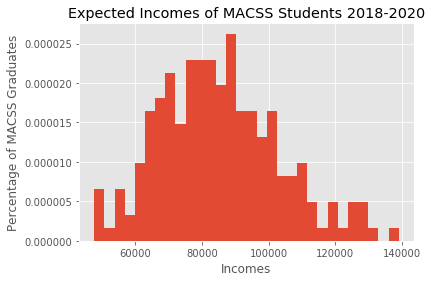

In [4]:
plt.hist(incomes, bins = 30, normed = True, label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")

## b) Estimate the parameters of the lognormal distribution by generalized method of moments

In [5]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)

gmm_args = (incomes, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

GMM1_Value = criterion(params_init, *gmm_args)[0][0]
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1, "criterion value=", GMM1_Value)

mu_GMM1= 11.336910231  sig_GMM1= 0.213027684722 criterion value= 0.390131083226


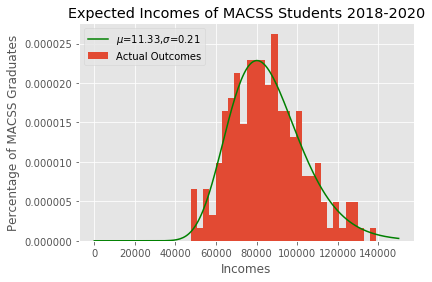

In [6]:
plt.hist(incomes, bins = 30, normed = True, label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM1, sig_GMM1, 150000), color = 'g', label = '$\mu$=11.33,$\sigma$=0.21')
plt.legend(loc = 'upper left')

## c) Two-Step GMM Estimation

In [7]:
err1 = err_vec(inc_sim, mu_GMM1, sig_GMM1, 150000, False)
VCV2 = np.dot(err1, err1.T) / inc_sim.shape[0]
print(VCV2)
W_hat2 = lin.pinv(VCV2)
print(W_hat2)

[[  9.38781302e-05  -4.01858665e-04]
 [ -4.01858665e-04   1.72021307e-03]]
[[  28.52634944 -122.11108886]
 [-122.11108886  522.71385287]]


In [8]:
#step 2: re-estimate the GMM estimator
params_init1 = np.array([mu_GMM1, sig_GMM1])
gmm_args2 = (incomes, 150000, W_hat2)
results2 = opt.minimize(criterion, params_init1, args=(gmm_args2),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x

# get criterion function values at the estimated GMM parameter values
params_GMM2 = np.array([mu_GMM2, sig_GMM2])
GMM2_Value = criterion(params_GMM2, *gmm_args2)[0][0]

# compare model moments and data moments
mean_data, std_data = data_moments(incomes)
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 150000)
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2, "criterion value:", GMM2_Value)
print('mean of data: {:.5f} and standard deviation of that {:.5f}'.format(mean_data,std_data))
print('mean of model: {:.5f} and standard deviation of that {:.5f}'.format(mean_model2,std_model2))

mu_GMM2= 11.3369101613  sig_GMM2= 0.213027093955 criterion value: 2.20854010886e-13
mean of data: 85276.82361 and standard deviation of that 17992.54213
mean of model: 85276.80910 and standard deviation of that 17992.54104


##### we nototiced that even though the parameters did not change much, the criterion value is significatly smaller

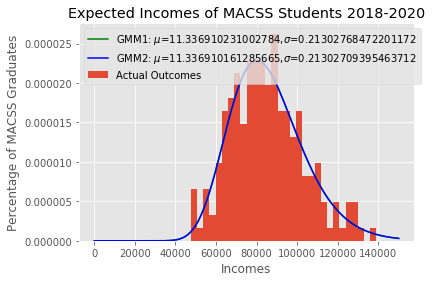

In [9]:
inc_sim = np.linspace(0.000001, 150000, 200)
plt.hist(incomes, bins = 30, normed = True, label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM1, sig_GMM1, 150000), color = 'g', label = 'GMM1: $\mu$={},$\sigma$={}'.format(mu_GMM1,sig_GMM1))
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM2, sig_GMM2, 150000), color = 'b', label = 'GMM2: $\mu$={},$\sigma$={}'.format(mu_GMM2,sig_GMM2))
plt.legend(loc = 'upper left')

##### here we note that the two lines are almost identical

## d) GMM Estimate With 3 Moments

In [10]:
#3 moments
def data_moments3(xvals):
    bpct_1 = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2 = (xvals[(xvals >=75000) & (xvals <= 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3 = xvals[xvals > 100000].shape[0] / xvals.shape[0]
    
    return bpct_1, bpct_2, bpct_3

def model_moments3(mu, sigma, cutoff):
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.001, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, cutoff, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion3(params, *args):
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec3(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val    


In [11]:
mu_init1 = 11
sig_init1 = 0.5
params_init2 = np.array([mu_init1, sig_init1])
W_hat3 = np.eye(3) 

gmm_args3 = (incomes, 150000, W_hat3)
results3 = opt.minimize(criterion3, params_init2, args=(gmm_args3),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None))) 
mu_GMM_3, sig_GMM_3 = results3.x

# critereon function at new values
params_GMM3 = np.array([mu_GMM_3, sig_GMM_3])
GMM3_Value = criterion3(params_GMM3, *gmm_args3)[0][0]

# compare model moments and data moments
print('data moments:\n',data_moments3(incomes))
print('model moments:\n', model_moments3(mu_GMM_3, sig_GMM_3, 150000))


print("mu:",mu_GMM_3, "sigma:",sig_GMM_3, "criterion value:", GMM3_Value)



data moments:
 (0.3, 0.5, 0.2)
model moments:
 (0.2992724536815684, 0.49805745520047146, 0.19966278325795728)
mu: 11.3367266466 sigma: 0.21174642036 criterion value: 0.23818173309


### Plot Results

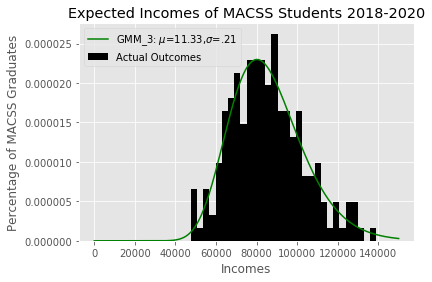

In [12]:
inc_sim = np.linspace(0.0001, 150000, 200)
plt.hist(incomes, bins = 30, normed = True, color = "black",label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM_3, sig_GMM_3, 150000), color = 'green', label = 'GMM_3: $\mu$=11.33,$\sigma$=.21')
plt.legend(loc = 'upper left')

## e) GMM Estimate New Moments

In [17]:
# step 1: use vector of moment error function from part b to get a new estimate of the inverse variance-covariance matrix
err_3 = err_vec3(incomes, mu_GMM_3, sig_GMM_3, 150000, False) 
VCV_3 = np.dot(err_3, err_3.T) / incomes.shape[0] 
W_hat2_3 = lin.pinv(VCV_3) 

#step 2: re-estimate the GMM estimator
params_init_3 = np.array([mu_GMM_3, sig_GMM_3]) 
gmm_args2_3 = (incomes, 150000, W_hat2_3)
results3_2 = opt.minimize(criterion3, params_init_3, args=(gmm_args2_3), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None))) 
mu_GMM2_3, sig_GMM2_3 = results3_2.x 

params_GMM2_3 = np.array([mu_GMM2_3, sig_GMM2_3])
GMM4_Value = criterion3(params_GMM2_3, *gmm_args2_3)[0][0]


print('data moments:\n',data_moments3(incomes))
print('model moments:\n', model_moments3(mu_GMM2_3, sig_GMM2_3, 150000))

print("mu:",mu_GMM2_3, "sigma:",sig_GMM2_3, "criterion value:", GMM4_Value)

data moments:
 (0.3, 0.5, 0.2)
model moments:
 (0.041593393899275286, 0.3997668905191436, 0.5401668474918273)


TypeError: 'NoneType' object is not subscriptable

### Histogram

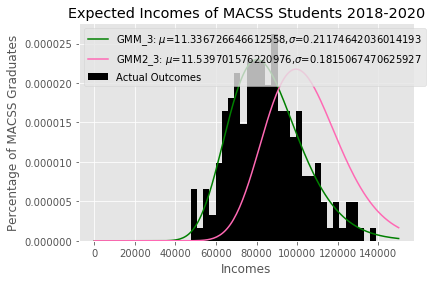

In [14]:
inc_sim = np.linspace(0.0001, 150000, 200)
plt.hist(incomes, bins = 30, normed = True, color = 'k', label = 'Actual Outcomes')
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM_3, sig_GMM_3, 150000), color = 'green', label = 'GMM_3: $\mu$={},$\sigma$={}'.format(mu_GMM_3, sig_GMM_3))
plt.plot(inc_sim, trunc_lognorm_pdf(inc_sim, mu_GMM2_3, sig_GMM2_3, 150000), color = 'hotpink', label = 'GMM2_3: $\mu$={},$\sigma$={}'.format(mu_GMM2_3, sig_GMM2_3))

plt.legend(loc = 'upper left')

## f) Which of the four estimations from parts (b), (c), (d), and (e) fits the data best?

C is the best because it has the smallest criterion value

# 2) Linear regression and GMM 

In [15]:
def err_vec_lin(xvals, b0, b1, b2, b3): # call data and model statistics to compute error matrix

    moms_data = np.array([xvals['sick']])
    moms_model = b0 + b1*xvals['age'] + b2*xvals['children'] + b3*xvals['avgtemp_winter']
    moms_model = np.array([moms_model])
    
    err_vec = moms_model - moms_data
    
    return err_vec

def criterion_lin(params, *args): # compute the criterion function
  
    b0, b1, b2, b3 = params
    xvals, W = args
    err = err_vec_lin(xvals, b0, b1, b2, b3) # get error matrix
    crit_val = np.dot(np.dot(err, W), err.T)  
    
    return crit_val

In [16]:
# set parameters for the minimizer
b0_init = 1 # initial guess for four parameters
b1_init = 0
b2_init = 0
b3_init = 0
  
params_init_lin = np.array([b0_init, b1_init, b2_init, b3_init]) 
W_hat_lin = np.eye(200) # use simple identity matrix as weighting matrix
gmm_args_lin = (sick, W_hat_lin) # plug in data and the weighting matrix)

results_lin = opt.minimize(criterion_lin, params_init_lin, args=(gmm_args_lin), method='L-BFGS-B') 
b0_gmm, b1_gmm, b2_gmm, b3_gmm = results_lin.x # unpack estimated parameters

# get criterion function values at the estimated GMM parameter values
params_GMM_lin = np.array([b0_gmm, b1_gmm, b2_gmm, b3_gmm])
GMM_Value_lin = criterion_lin(params_GMM_lin, *gmm_args_lin)[0][0]

print("My parameter estimates are:" , b0_gmm, b1_gmm, b2_gmm, b3_gmm)
print("My criterion value is : ", GMM_Value_lin )

My parameter estimates are: 0.251644863587 0.0129334709621 0.400500984743 -0.00999170970796
My criterion value is :  0.00182128980608
